In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import sys
import tensorflow as tf

sys.path.append('..')
from src.data.make_dataset import make_dataset

In [5]:
df = pd.read_csv('../data/processed/EEA-SK-Ba-trend.csv')
df = df[['PM10 Concentration', 'PM2.5 Concentration']]
scaler = MinMaxScaler()
df = scaler.fit_transform(df)
df = scaler.transform(df)


c:\Users\Gamebox\Desktop\2024_CambalS_Adaptive_continuous_environment_remote_sensing\DPenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [6]:
train_X, train_Y, val_X, val_Y, test_X = load_data(data_src=df, n_past=24, n_future=1)

In [7]:
print(f'Train set shape: {train_X.shape}         Train labels shape: {train_Y.shape}')
print(f'Validation set shape: {val_X.shape}     Validation labels shape: {val_Y.shape}')
print(f'Test set shape: {test_X.shape}')

Train set shape: (24522, 24, 2)         Train labels shape: (24522, 1, 2)
Validation set shape: (3482, 24, 2)     Validation labels shape: (3482, 1, 2)
Test set shape: (6990, 24, 2)


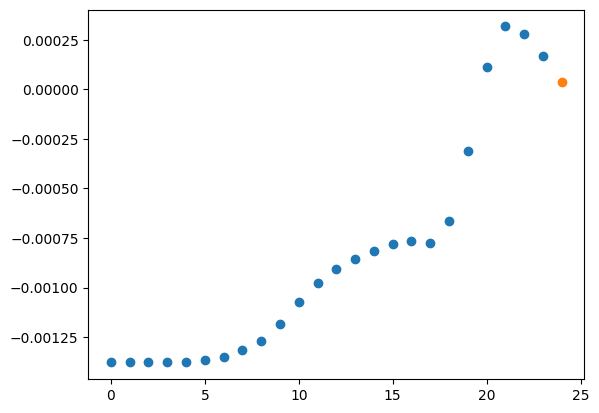

In [8]:
plt.scatter(range(24), train_X[0, :, 0], label='PM10')
tmp = np.empty((24, 1))
tmp[:] = np.nan
tmp = np.append(tmp, np.array(train_Y[0, 0, 0]))
plt.scatter(range(25), tmp, label='PM2.5')

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2, mode='min')

### Model n.1